## 1) What is PyTorch?
PyTorch is a deep learning framework built around tensors and automatic differentiation. It provides:
- Tensors with GPU acceleration
- Autograd for automatic gradients
- Modules for building neural networks
- Optimizers and training utilities


In [1]:
import torch
print(torch.__version__)

2.9.1


## 2) Tensors and basic creation
Tensors are n-dimensional arrays. You can create them from lists, NumPy arrays, or with helpers.

In [2]:
import torch

# Scalars, vectors, matrices
scalar = torch.tensor(3.14)
vector = torch.tensor([1.0, 2.0, 3.0])
matrix = torch.tensor([[1, 2], [3, 4]])

print(scalar, scalar.shape)
print(vector, vector.shape)
print(matrix, matrix.shape)

# Common initializations
zeros = torch.zeros((2, 3))
ones = torch.ones((2, 3))
rand = torch.rand((2, 3))

print(zeros)
print(ones)
print(rand)

tensor(3.1400) torch.Size([])
tensor([1., 2., 3.]) torch.Size([3])
tensor([[1, 2],
        [3, 4]]) torch.Size([2, 2])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[0.4753, 0.6430, 0.2538],
        [0.3366, 0.2775, 0.2391]])


## 3) Tensor attributes and device
Tensors carry dtype and device (CPU/GPU). Use `.to(device)` to move them.

In [3]:
x = torch.randn(3, 3, dtype=torch.float32)
print(x.dtype, x.device)

# If CUDA is available, move to GPU
if torch.cuda.is_available():
    x = x.to('cuda')
    print('moved to', x.device)

torch.float32 cpu


## 4) Autograd basics
Autograd tracks operations on tensors with `requires_grad=True` so gradients can be computed.

In [9]:
from numpy import gradient


w = torch.tensor(2.0, requires_grad=True)

x = torch.tensor(3.0, requires_grad=True) # mentioned requires_grad = True if you want to compute gradients with respect to this tensor
y = w * x**2 + 1

# Backprop
y.backward() # compute the derivative at x=3 dy/dx
print('y:', y.item())
x_grad = x.grad
print('dy/dx:', x_grad) 
print('dy/dw:', w.grad)

y: 19.0
dy/dx: tensor(12.)
dy/dw: tensor(9.)


## 5) Building a simple model
Use `nn.Module` to define models and `nn.Linear` for linear layers.

In [10]:
import torch.nn as nn

class SimpleLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(1, 1)

    def forward(self, x):
        return self.layer(x)

model = SimpleLinear()
print(model)

SimpleLinear(
  (layer): Linear(in_features=1, out_features=1, bias=True)
)


## 6) Loss and optimizer
Loss functions measure prediction error and optimizers update parameters.

In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Dummy data
X = torch.tensor([[1.0], [2.0], [3.0], [4.0]])
Y = torch.tensor([[2.0], [4.0], [6.0], [8.0]])

# Forward pass
preds = model(X)
loss = criterion(preds, Y)
print('loss:', loss.item())

# Backward + update
optimizer.zero_grad()
loss.backward()
optimizer.step()

loss: 66.84538269042969


## 7) Training loop example (linear regression)
A full training loop ties together forward, loss, backward, and update.

In [12]:
model = SimpleLinear()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(50):
    preds = model(X)
    loss = criterion(preds, Y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'epoch {epoch+1}: loss={loss.item():.4f}')

epoch 10: loss=0.0302
epoch 20: loss=0.0068
epoch 30: loss=0.0037
epoch 40: loss=0.0020
epoch 50: loss=0.0011


## 8) Saving and loading models
Persist the model weights with `state_dict`.

In [ ]:
# Save
path = 'simple_linear.pt'
torch.save(model.state_dict(), path)

# Load
loaded = SimpleLinear()
loaded.load_state_dict(torch.load(path, map_location='cpu'))
loaded.eval()
print('loaded ok')

## 9) Mini exercise
- Create a 2-layer MLP with ReLU.
- Train it to fit a small synthetic dataset (e.g., y = x^2).
- Print loss every 20 epochs.


In [22]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, in_features, hidden_units, num_layers=1):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_features, hidden_units))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_units, hidden_units))
        self.layers.append(nn.Linear(hidden_units, 1))  # single logit

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)  # logits
        return x

model = MultiLayerPerceptron(in_features=10, hidden_units=32, num_layers=2)
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from torchinfo import summary

summary(model, input_size=(64, 10))


Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerPerceptron                     [64, 1]                   --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [64, 32]                  352
│    └─Linear: 2-2                       [64, 32]                  1,056
│    └─Linear: 2-3                       [64, 1]                   33
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.01
Estimated Total Size (MB): 0.04

In [23]:
# Dummy data
X = torch.randn(64, 10)  # example input
y = torch.randint(0, 2, (64, 1)).float()  # example binary labels
# initial weight
# print(list(model.parameters())[0])
epochs = 100
losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss_value = loss(outputs, y)
    print(loss_value)
    loss_value.backward()
    optimizer.step()
    losses.append(loss_value.item())

tensor(0.6989, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6974, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6958, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6943, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6929, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6915, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6902, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6888, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6875, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6863, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6850, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6838, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6825, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6813, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6800, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6787, grad_fn=<BinaryCrossEntro

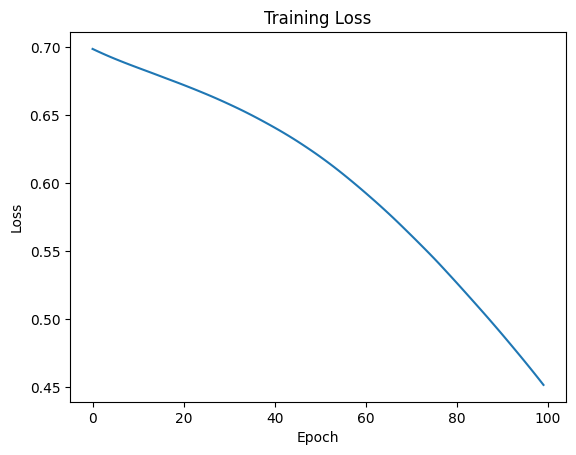

In [24]:
from matplotlib import pyplot as plt


plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()